This is a companion notebook for the book [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff). For readability, it only contains runnable code blocks and section titles, and omits everything else in the book: text paragraphs, figures, and pseudocode.

**If you want to be able to follow what's going on, I recommend reading the notebook side by side with your copy of the book.**

This notebook was generated for TensorFlow 2.6.

# Deep Learning For Timeseries

## A Temperature-Forcasting Example

### Jena Weather Dataset

**Downloading and uncompressing dataset**

In [ ]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

**Settings**

In [4]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np
from numpy.lib.stride_tricks import as_strided

import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm

if torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = "cpu"

**Inspecting the data of the Jena weather dataset**

In [5]:
import os
fname = os.path.join("jena_climate_2009_2016.csv") 
with open(fname) as f:
    data = f.read()
lines = data.split("\n") 
header = lines[0].split(",") 
lines = lines[1:] 
print(header) 
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


**Parsing the data**

In [6]:
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1)) 
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1] 
    raw_data[i, :] = values[:]

**Plotting the temperature timeseries**

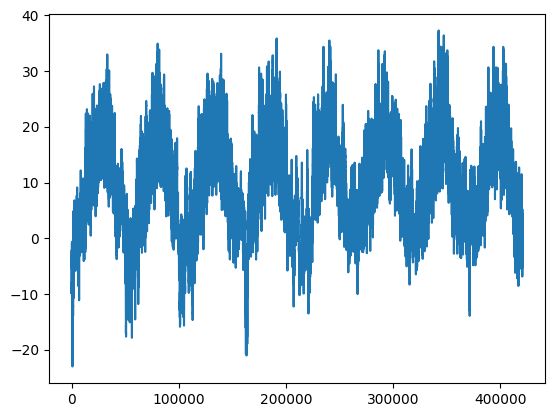

In [7]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)

**Plotting the first 10 days of the temperature timeseries**

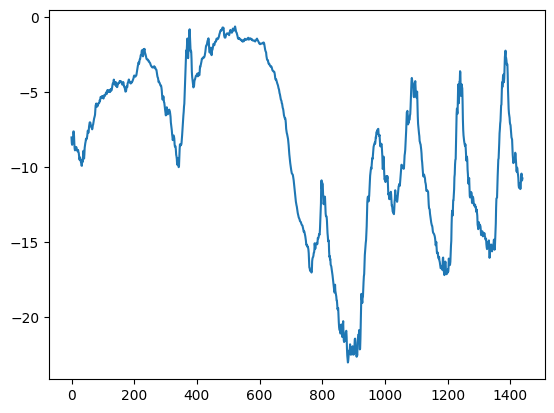

In [8]:
plt.plot(range(1440), temperature[:1440])

**Computing the number of samples we’ll use for each data split**

In [13]:
from torch.utils.data import Dataset, DataLoader
csv_path = "jena_climate_2009_2016.csv"
f = open(csv_path)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]


float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std


class dataset(Dataset):
    def __init__(self, data, lookback, delay, min_index, max_index, step=6, inverse_order = False):
        super(dataset).__init__()
        if max_index is None:
            max_index = len(data)
        self.inverse_order = inverse_order

        self.samples = torch.zeros(max_index - min_index+ lookback, lookback // step, data.shape[-1])
        self.targets = torch.zeros(max_index - min_index+ lookback, 1)
            
        for i in range(len(self.samples)):
            indices = range(i - lookback, i, step)
            self.samples[i] = torch.tensor(data[indices]).float()
            self.targets[i] = torch.tensor(data[i + delay][1]).float()
    
    def __len__(self):
        return len(self.samples)

    def __getitem__(self, index):
        samples = self.samples[index]
        targets = self.targets[index]

        if self.inverse_order:
            return samples[:,::-1,:], targets
        else:
            return samples, targets



def generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield torch.tensor(samples).float(), torch.tensor(targets).float()

def reverse_order_generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield torch.tensor(samples[:, ::-1, :]).float(), torch.tensor(targets).float()

In [14]:
ori_float_data = float_data

In [15]:
def plot_history(history):
    fig = plt.figure(figsize=(10, 5))

    plt.figure()
    plt.plot(history['loss'], label='Train')
    plt.plot(history['val_loss'], label='Val')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()
    
    print('Max validation mae:', max(history['val_loss']))

**Computing the number of samples we’ll use for each data split**

In [78]:
num_train_samples = int(0.5 * len(raw_data)) 
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples

print("num_train_samples:", num_train_samples) 
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


**Normalizing the data and instantiating datasets for training, validation, and testing** 

In [ ]:
def gen_dataset(float_data, lookback, step, delay, batch_size):    
    # train_gen = generator(float_data, lookback=lookback, delay=delay, min_index=0, max_index=200000, shuffle=True, step=step, batch_size=batch_size)
    train_data = dataset(float_data, lookback=lookback, delay=delay, min_index=0, max_index=num_train_samples, step=step)
    val_data = dataset(float_data, lookback=lookback, delay=delay, min_index=num_train_samples, max_index=num_train_samples+num_val_samples, step=step)
    test_data = dataset(float_data, lookback=lookback, delay=delay, min_index=num_train_samples+num_val_samples, max_index=None, step=step)

    train_gen = DataLoader(train_data, batch_size, shuffle=True)
    val_gen = DataLoader(val_data, batch_size, shuffle=False)
    test_gen = DataLoader(test_data, batch_size, shuffle=False)

    return float_data, train_gen, val_gen, test_gen, lookback, step

In [23]:
class Trainer(object):
    def __init__(self, train_dataloader, val_dataloader, model, lr, checkname):
        self.lr = lr
        self.checkname = checkname
        
        self.train_dataloader = train_dataloader
        self.val_dataloader = val_dataloader
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        self.model = model
        self.model = self.model.to(self.device)
        
        self.criterion = torch.nn.MSELoss()
        self.eval_metric = torch.nn.L1Loss()
        self.optimizer = torch.optim.RMSprop(self.model.parameters(), lr = self.lr)
       
        self.checkname = self.checkname
        self.save_root = os.path.join('./jena_ckpts', self.checkname)
        if not os.path.exists(self.save_root):
            os.mkdir(self.save_root)
        self.best_pred = 0
        self.eval_best_loss = 10000000
        self.history = {'loss':[], 'val_loss':[]}

    def training(self, epoch):
        self.model.train()
        self.total_loss = 0
        self.train_acc = 0
        for i, (item) in (enumerate(self.train_dataloader)):
            if len(item) == 3:
                label, data, off = item
                off = off.to(self.device)
            else:
                data, label = item
            data, label = data.to(self.device), label.to(self.device)
            self.optimizer.zero_grad() 
            if len(item) == 2:
                pred = self.model(data) 
            elif len(item) == 3:
                pred = self.model(data, off)
            loss = self.criterion(pred, label)
            loss.backward() 
            self.optimizer.step() 
            self.total_loss += loss 
            
        print('Training loss : %.5f'%(self.total_loss/(i+1)))
        self.history['loss'].append((self.total_loss/(i+1)).cpu().item())
        
        
    def validation(self, epoch):
        self.model.eval() 
        self.val_loss = 0
        self.eval_metric_loss = 0
        self.val_acc = 0
        for i, (item) in (enumerate(self.val_dataloader)):
            if len(item) == 3:
                label, data, off = item
                off = off.to(self.device)
            else:
                data, label = item  
            data, label = data.to(self.device), label.to(self.device)
            with torch.no_grad():
                if len(item) == 2:
                    pred = self.model(data) 
                elif len(item) == 3:
                    pred = self.model(data, off)
                    
                eval_loss = self.eval_metric(pred, label)
                self.eval_metric_loss += eval_loss 
                    
                loss = self.criterion(pred, label) 
                self.val_loss += loss
           
        print('Validation loss : %.5f'%(self.val_loss/(i+1)))
        print('Validation metric Loss : %.5f'%(self.eval_metric_loss/(i+1)))
        self.history['val_loss'].append((self.val_loss/(i+1)).cpu().item())

        if self.eval_best_loss > self.eval_metric_loss:
            self.eval_best_loss = self.eval_metric_loss
            torch.save(self.model.state_dict(), os.path.join(self.save_root, 'model_best.pth'))

    def evaluate_loader(self, loader):
        self.model.load_state_dict(torch.load(os.path.join(self.save_root, 'model_best.pth')))
        self.model.eval() 
        self.val_loss = 0
        self.eval_metric_loss = 0
        self.val_acc = 0
        for i, (item) in (enumerate(loader)):
            if len(item) == 3:
                label, data, off = item
                off = off.to(self.device)
            else:
                data, label = item  
            data, label = data.to(self.device), label.to(self.device)
            with torch.no_grad():
                if len(item) == 2:
                    pred = self.model(data) 
                elif len(item) == 3:
                    pred = self.model(data, off)
                    
                eval_loss = self.eval_metric(pred, label)
                self.eval_metric_loss += eval_loss 
                    
                loss = self.criterion(pred, label) 
                self.val_loss += loss
           
        print('Test loss : %.5f'%(self.val_loss/(i+1)))
        print('Test metric Loss (MAE) : %.5f'%(self.eval_metric_loss/(i+1)))

In [24]:
def fit(trainer, epochs):
    trainer.history = {'loss':[], 'val_loss':[]}

    for epoch in range(epochs):
        print('Epoch :', str(epoch))
        trainer.training(epoch) 
        trainer.validation(epoch)
    print('Best prediction (L1 loss) on Validation set :', trainer.eval_best_loss.item())

In [29]:
sampling_rate = 6 
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1) 
batch_size = 256

_, train_gen720, val_gen720, test_gen720, lookback720, step720 = gen_dataset(ori_float_data, sampling_rate*sequence_length, sampling_rate, delay, batch_size) 

**Training and evaluating a densely connected model**

Epoch : 0
Training loss : 0.76979
Validation loss : 2.37568
Validation metric Loss : 1.23284
Epoch : 1
Training loss : 0.73720
Validation loss : 0.96709
Validation metric Loss : 0.79100
Epoch : 2
Training loss : 0.74191
Validation loss : 0.98301
Validation metric Loss : 0.79713
Epoch : 3
Training loss : 0.74333
Validation loss : 0.78544
Validation metric Loss : 0.68545
Epoch : 4
Training loss : 0.74042
Validation loss : 2.17230
Validation metric Loss : 1.18801
Epoch : 5
Training loss : 0.74341
Validation loss : 0.86775
Validation metric Loss : 0.73668
Epoch : 6
Training loss : 0.74028
Validation loss : 0.91285
Validation metric Loss : 0.75996
Epoch : 7
Training loss : 0.74555
Validation loss : 0.99506
Validation metric Loss : 0.80220
Epoch : 8
Training loss : 0.74884
Validation loss : 0.75788
Validation metric Loss : 0.67001
Epoch : 9
Training loss : 0.75052
Validation loss : 0.78756
Validation metric Loss : 0.68690
Best prediction (L1 loss) on Validation set : 277.3855285644531


<Figure size 1000x500 with 0 Axes>

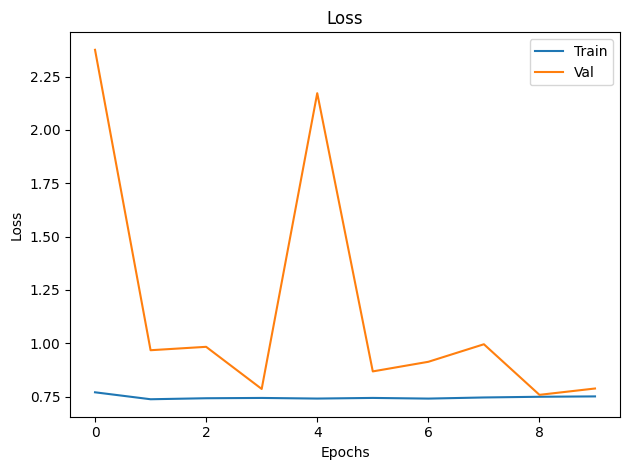

Max validation mae: 2.375680923461914
Test loss : 0.75790
Test metric Loss (MAE) : 0.67002


In [31]:
import torch.nn as nn

## Simple FCN
class FCN(nn.Module):
    def __init__(self, input_size, output_size):
        super(FCN, self).__init__()

        self.fc1 = nn.Linear(input_size, output_size)
        self.act1 = nn.ReLU()        

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = self.act1(self.fc1(x))
        return x

fcn = FCN(lookback720 // step720 * 14, 1)
fcn_Trainer = Trainer(train_gen720, val_gen720, fcn, 0.001, 'fcn')
fit(fcn_Trainer, 10)

plot_history(fcn_Trainer.history)

fcn_Trainer.evaluate_loader(test_gen720)

**Try a 1D convolutional model**

Epoch : 0
Training loss : 0.32606
Validation loss : 3.15761
Validation metric Loss : 1.35030
Epoch : 1
Training loss : 0.25103
Validation loss : 0.24375
Validation metric Loss : 0.38586
Epoch : 2
Training loss : 0.21973
Validation loss : 0.19666
Validation metric Loss : 0.34562
Epoch : 3
Training loss : 0.20179
Validation loss : 0.28716
Validation metric Loss : 0.42628
Epoch : 4
Training loss : 0.18819
Validation loss : 0.79034
Validation metric Loss : 0.67947
Epoch : 5
Training loss : 0.17761
Validation loss : 1.72664
Validation metric Loss : 0.97876
Epoch : 6
Training loss : 0.16911
Validation loss : 0.17227
Validation metric Loss : 0.32583
Epoch : 7
Training loss : 0.16039
Validation loss : 0.44065
Validation metric Loss : 0.51512
Epoch : 8
Training loss : 0.15350
Validation loss : 0.47230
Validation metric Loss : 0.52463
Epoch : 9
Training loss : 0.14878
Validation loss : 0.19258
Validation metric Loss : 0.33323
Best prediction (L1 loss) on Validation set : 134.89381408691406


<Figure size 1000x500 with 0 Axes>

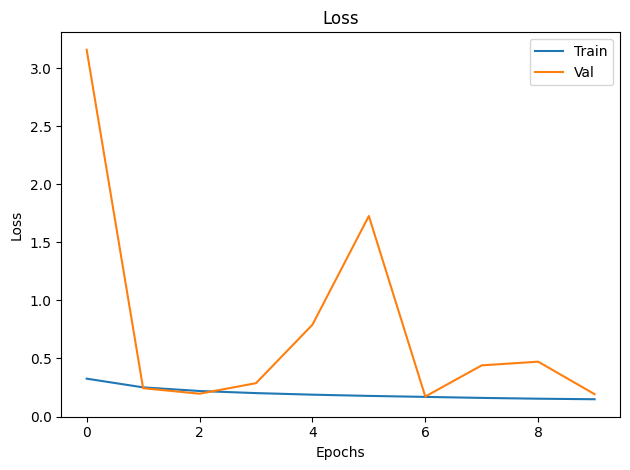

Max validation mae: 3.1576104164123535
Test loss : 0.17227
Test metric Loss (MAE) : 0.32583


In [77]:
class conv1D(nn.Module):
    def __init__(self, input_size):
        super(conv1D, self).__init__()
        self.conv1 = nn.Conv1d(14, 8, kernel_size=24)
        self.relu = nn.ReLU()
        self.maxpool1 = nn.MaxPool1d(kernel_size=2)
        self.conv2 = nn.Conv1d(8, 8, kernel_size=12)
        self.maxpool2 = nn.MaxPool1d(kernel_size=2)
        self.conv3 = nn.Conv1d(8, 8, kernel_size=6)
        self.fc1 = nn.Linear(13, 1)
        self.global_avg_pool = nn.AvgPool1d(1)
        self.fc2 = nn.Linear(8, 1)

    def forward(self, x):
        x=x.permute(0,2,1)
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool2(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = self.fc1(x)
        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc2(x)
        return x

conv = conv1D(sequence_length)
conv_Trainer = Trainer(train_gen720, val_gen720, conv, 0.001, 'fcn')
fit(conv_Trainer, 10)

plot_history(conv_Trainer.history)

conv_Trainer.evaluate_loader(test_gen720)

**Try a simple LSTM-based model**

Epoch : 0
Training loss : 0.31023
Validation loss : 0.34302
Validation metric Loss : 0.47064
Epoch : 1
Training loss : 0.26770
Validation loss : 0.26768
Validation metric Loss : 0.40531
Epoch : 2
Training loss : 0.23059
Validation loss : 0.19854
Validation metric Loss : 0.35108
Epoch : 3
Training loss : 0.20169
Validation loss : 0.23961
Validation metric Loss : 0.38000
Epoch : 4
Training loss : 0.17625
Validation loss : 0.23757
Validation metric Loss : 0.37968
Epoch : 5
Training loss : 0.15930
Validation loss : 0.18811
Validation metric Loss : 0.33927
Epoch : 6
Training loss : 0.14640
Validation loss : 0.15233
Validation metric Loss : 0.30200
Epoch : 7
Training loss : 0.12782
Validation loss : 0.18397
Validation metric Loss : 0.33055
Epoch : 8
Training loss : 0.12060
Validation loss : 0.11331
Validation metric Loss : 0.26238
Epoch : 9
Training loss : 0.11334
Validation loss : 0.12143
Validation metric Loss : 0.26612
Best prediction (L1 loss) on Validation set : 108.6263656616211


<Figure size 1000x500 with 0 Axes>

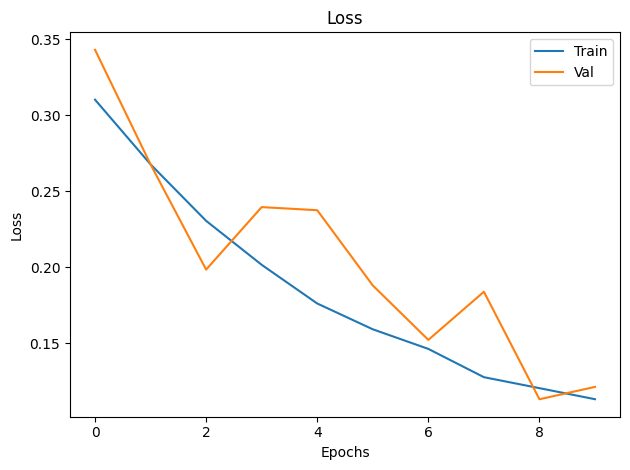

Max validation mae: 0.3430166244506836
Test loss : 0.11331
Test metric Loss (MAE) : 0.26238


In [37]:
import torch.nn as nn

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size

        self.rnn = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        batch_size = x.size(0)

        (h0, c0) = self.init_hidden(batch_size)

        out, (h0, c0) = self.rnn(x, (h0, c0))
        out = out[:, -1, :].view(-1, self.hidden_size)
        out = self.fc(out)
        return out

    def init_hidden(self, batch_size):
        return (torch.zeros(1, batch_size, self.hidden_size).to(torch.device('cuda' if torch.cuda.is_available() else 'cpu')), 
                torch.zeros(1, batch_size, self.hidden_size).to(torch.device('cuda' if torch.cuda.is_available() else 'cpu')))

lstm = LSTM(14, 32, 1)
lstm_Trainer = Trainer(train_gen720, val_gen720, lstm, 0.001, 'lstm')
fit(lstm_Trainer, 10)

plot_history(lstm_Trainer.history)

lstm_Trainer.evaluate_loader(test_gen720)